https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

## One-Step univariate time series forecast


In [1]:
# univariate data preparation
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import pandas as pd
import myLibrary as mL
from sklearn.metrics import mean_squared_error, mean_absolute_error

---
# Parameters:

In [2]:
STATIONS = ["42036"]    # 33.61% NaN values -> Best value for GOM and 2022
YEARS = ["2022"]
NAN_THRESHOLD = 1
FEATURES = ["WTMP"]
ERA5=True

# when data is converted to stationary data, the observed values are replaced by the difference between value(t) and value(t-STATIONARY_SHIFT)
STATIONARY_SHIFT = 1
lag=1
n_test_hours = 7*24

----
# Preparation

<details>
<summary>Titel des Abschnitts</summary>
Text, der ein- und ausgeblendet werden soll.

In [3]:
data = mL.get_data(
    stations=STATIONS,
    years=YEARS,
    nan_threshold=NAN_THRESHOLD,
    features=FEATURES,
    #features=None,
    era5=ERA5
    )

data

Started with  2022 . Previous year took:   0.0003628730773925781 seconds
from disc
Finished downloading - now merging it together!
Started with  2022 . Previous year took:   0.0 seconds
Finished downloading - now merging it together!


,WTMP_42036,WTMP_42036_ERA5
timestamp,,
2022-01-01 00:00:00,23.0,22.942808
2022-01-01 01:00:00,23.0,22.942808
2022-01-01 02:00:00,23.0,22.942808
2022-01-01 03:00:00,23.0,22.942808
2022-01-01 04:00:00,23.0,22.942808
...,...,...
2022-12-31 19:00:00,22.0,21.524296
2022-12-31 20:00:00,22.0,21.524296
2022-12-31 21:00:00,22.1,21.524296


<AxesSubplot:xlabel='timestamp'>

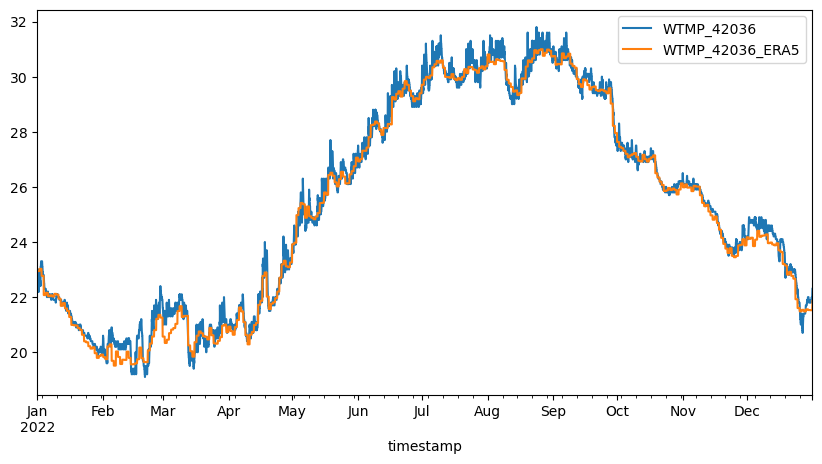

In [4]:
data.plot( figsize=(10, 5))

-----
# Data Preperation:

## 1. Make data stationary

In [46]:
data_stationary = mL.data_to_stationary(data, n = STATIONARY_SHIFT)
data_stationary.head()

,WTMP_42036,WTMP_42036_ERA5
timestamp,,
2022-01-01 01:00:00,0.0,0.0
2022-01-01 02:00:00,0.0,0.0
2022-01-01 03:00:00,0.0,0.0
2022-01-01 04:00:00,0.0,0.0
2022-01-01 05:00:00,0.0,0.0


## 2. Transform to supervised problem

In [47]:
data_supervised = mL.data_to_supervised(data_stationary)
data_supervised.head()

,WTMP_42036(t-1),WTMP_42036_ERA5(t-1),WTMP_42036(t),WTMP_42036_ERA5(t)
timestamp,,,,
2022-01-01 02:00:00,0.0,0.0,0.0,0.0
2022-01-01 03:00:00,0.0,0.0,0.0,0.0
2022-01-01 04:00:00,0.0,0.0,0.0,0.0
2022-01-01 05:00:00,0.0,0.0,0.0,0.0
2022-01-01 06:00:00,0.0,0.0,-0.1,0.0


## train test split

In [48]:
train_X, train_y, test_X, test_y = mL.train_test_split(data_supervised, n_test_hours)
print("Shapes: ", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Shapes:  (8590, 1, 2) (8590, 2) (168, 1, 2) (168, 2)


## Normalize the data

In [49]:
# Scale the data
train_X_scaled, train_y_scaled, test_X_scaled, test_y_scaled, scaler = mL.scale_data(train_X,
                                                                                     train_y,
                                                                                     test_X,
                                                                                     test_y)

----
## Basic LSTM Model

In [50]:
# fit an LSTM network to training data
def fit_lstm(train_X, train_y):

    #design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(train_X.shape[2])) # Predict all features!
    model.compile(loss='mean_squared_error', optimizer='adam')

    # fit network
    model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=0, shuffle=False)

    return model

In [10]:
lstm_model = fit_lstm(train_X_scaled, train_y_scaled)
lstm_model.summary()

2023-04-24 10:06:33.930568: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10600     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 10,702
Trainable params: 10,702
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Forecast the entire training dataset to build up state for forecasting
def build_up_state(model):
    #Reset state
    model.reset_states()
    # forecast the entire training dataset to build up state for forecasting
    model.predict(train_X_scaled, batch_size=1)

# One-Shot Forecasting

In [12]:
build_up_state(lstm_model)

8590/8590 [==============================] - 3s 328us/step


In [24]:
output_cols = data_supervised.filter(regex='\(t[\+]*\)').columns.tolist()
yhat = lstm_model.predict(test_X_scaled)

true_value = data.tail(len(yhat)).copy()
true_value = true_value.reset_index(drop=True)

first_row = data.iloc[-len(yhat)-1]
yhat_unscaled = mL.invert_scaling(yhat, scaler)
yhat_true_value = mL.stationary_to_data(yhat_unscaled, first_row)
yhat_true_value_df = pd.DataFrame(yhat_true_value, columns=[name + "_pred" for name in output_cols])

evaluation_1 = pd.concat([true_value, yhat_true_value_df], axis=1)
evaluation_1

6/6 [==============================] - 0s 1ms/step


,WTMP_42036,WTMP_42036_ERA5,WTMP_42036(t)_pred,WTMP_42036_ERA5(t)_pred
0,22.2,21.601730,22.094070,21.598164
1,22.2,21.601730,22.093075,21.598381
2,22.1,21.601730,22.092739,21.596283
3,22.1,21.601730,22.086809,21.592716
4,22.0,21.601730,22.086473,21.590618
...,...,...,...,...
163,22.0,21.524296,21.883202,21.274618
164,22.0,21.524296,21.882866,21.272520
165,22.1,21.524296,21.882530,21.270422
166,22.2,21.862413,21.881535,21.270639


In [26]:
mae = mean_absolute_error(evaluation_1["WTMP_42036"], evaluation_1["WTMP_42036(t)_pred"])
mse = mean_squared_error(evaluation_1["WTMP_42036"], evaluation_1["WTMP_42036(t)_pred"])
print('MAE: ', mae)
print('MSE: ', mse)

MAE:  0.3629820778256372
MSE:  0.23983390099933755


<AxesSubplot:>

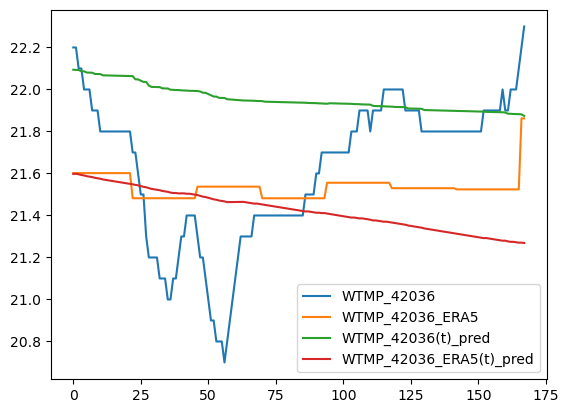

In [27]:
evaluation_1.plot(kind='line')

# 1-Week forecast

In [28]:
build_up_state(lstm_model)

8590/8590 [==============================] - 3s 327us/step


In [33]:
# make a one-step forecast
# This function helps with reshaping.
def single_forecast(model, x):
    x = x.reshape(1, 1, len(x[0]))
    yhat = model.predict(x, verbose=0)
    return yhat

In [34]:
# Prepare data structure
prediction_2 = pd.DataFrame(test_y, columns=output_cols)
for col in output_cols:
    prediction_2[f"{col}_pred"] = 0
prediction_2

,WTMP_42036(t),WTMP_42036_ERA5(t),WTMP_42036(t)_pred,WTMP_42036_ERA5(t)_pred
0,0.1,0.000000,0,0
1,0.0,0.000000,0,0
2,-0.1,0.000000,0,0
3,0.0,0.000000,0,0
4,-0.1,0.000000,0,0
...,...,...,...,...
163,0.0,0.000000,0,0
164,0.0,0.000000,0,0
165,0.1,0.000000,0,0
166,0.1,0.338116,0,0


In [51]:
#Forecast a whole week
prev_obs = test_X[0]
for i, row in prediction_2.iterrows():
    yhat = single_forecast(lstm_model, prev_obs)
    prev_obs = yhat
    #Mapping of array index and df column name
    for j, element in enumerate(output_cols):
        prediction_2.at[i, f"{element}_pred"] =yhat[0,j]

prediction_2

,WTMP_42036(t),WTMP_42036_ERA5(t),WTMP_42036(t)_pred,WTMP_42036_ERA5(t)_pred
0,0.1,0.000000,0.025977,0.030672
1,0.0,0.000000,0.039170,0.032007
2,-0.1,0.000000,0.039635,0.032288
3,0.0,0.000000,0.039657,0.032298
4,-0.1,0.000000,0.039658,0.032298
...,...,...,...,...
163,0.0,0.000000,0.039658,0.032298
164,0.0,0.000000,0.039658,0.032298
165,0.1,0.000000,0.039658,0.032298
166,0.1,0.338116,0.039658,0.032298


In [52]:
#Convert it to real values
first_row = data.iloc[-len(yhat)-1]

yhat = prediction_2[[name + "_pred" for name in output_cols]].values
yhat_unscaled = mL.invert_scaling(yhat, scaler)
yhat_true_value = mL.stationary_to_data(yhat_unscaled, first_row)
yhat_true_value_df = pd.DataFrame(yhat_true_value, columns=[name + "_pred" for name in output_cols])

evaluation_2 = pd.concat([true_value, yhat_true_value_df], axis=1)
evaluation_2

,WTMP_42036,WTMP_42036_ERA5,WTMP_42036(t)_pred,WTMP_42036_ERA5(t)_pred
0,22.2,21.601730,22.182471,21.858633
1,22.2,21.601730,22.181433,21.856237
2,22.1,21.601730,22.180977,21.854132
3,22.1,21.601730,22.180548,21.852037
4,22.0,21.601730,22.180120,21.849942
...,...,...,...,...
163,22.0,21.524296,22.112059,21.516880
164,22.0,21.524296,22.111631,21.514785
165,22.1,21.524296,22.111203,21.512690
166,22.2,21.862413,22.110775,21.510596


In [53]:
mae_2 = mean_absolute_error(evaluation_2["WTMP_42036"], evaluation_2["WTMP_42036(t)_pred"])
mse_2 = mean_squared_error(evaluation_2["WTMP_42036"], evaluation_2["WTMP_42036(t)_pred"])
print('MAE: ', mae_2)
print('MSE: ', mse_2)

MAE:  0.5278194938309003
MSE:  0.39893371119259685


<AxesSubplot:>

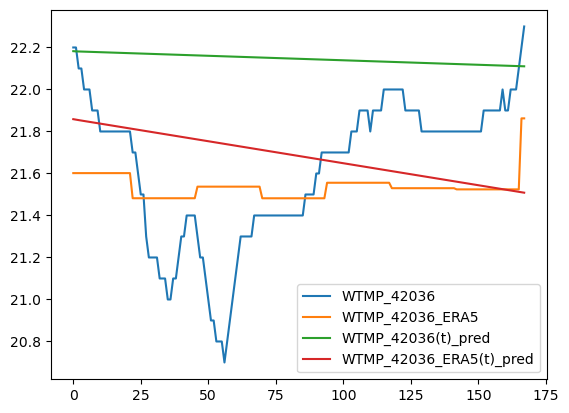

In [54]:
evaluation_2.plot(kind='line')